In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

Using 25 Fourier basis functions
Target coefficients computed. First 5: [ 0.9798801   0.0787666  -0.76391984 -0.06205444 -0.05465544]
Starting ergodic trajectory optimization...
Optimization completed. Success: False
Final cost: 0.006288
Total iterations: 59

Final ergodic metric: 0.001997
Target vs Final coefficients:
  k=[0 0]: target=0.9799, achieved=0.9800, diff=0.0001
  k=[1 0]: target=0.0788, achieved=0.0924, diff=0.0137
  k=[2 0]: target=-0.7639, achieved=-0.8109, diff=-0.0469
  k=[3 0]: target=-0.0621, achieved=-0.0372, diff=0.0249
  k=[4 0]: target=-0.0547, achieved=-0.0981, diff=-0.0434
  k=[0 1]: target=0.2578, achieved=0.2566, diff=-0.0011
  k=[1 1]: target=0.0722, achieved=0.0888, diff=0.0166
  k=[2 1]: target=-0.0170, achieved=-0.0484, diff=-0.0315
  k=[3 1]: target=-0.1062, achieved=-0.0773, diff=0.0290
  k=[4 1]: target=-0.3304, achieved=-0.3849, diff=-0.0544


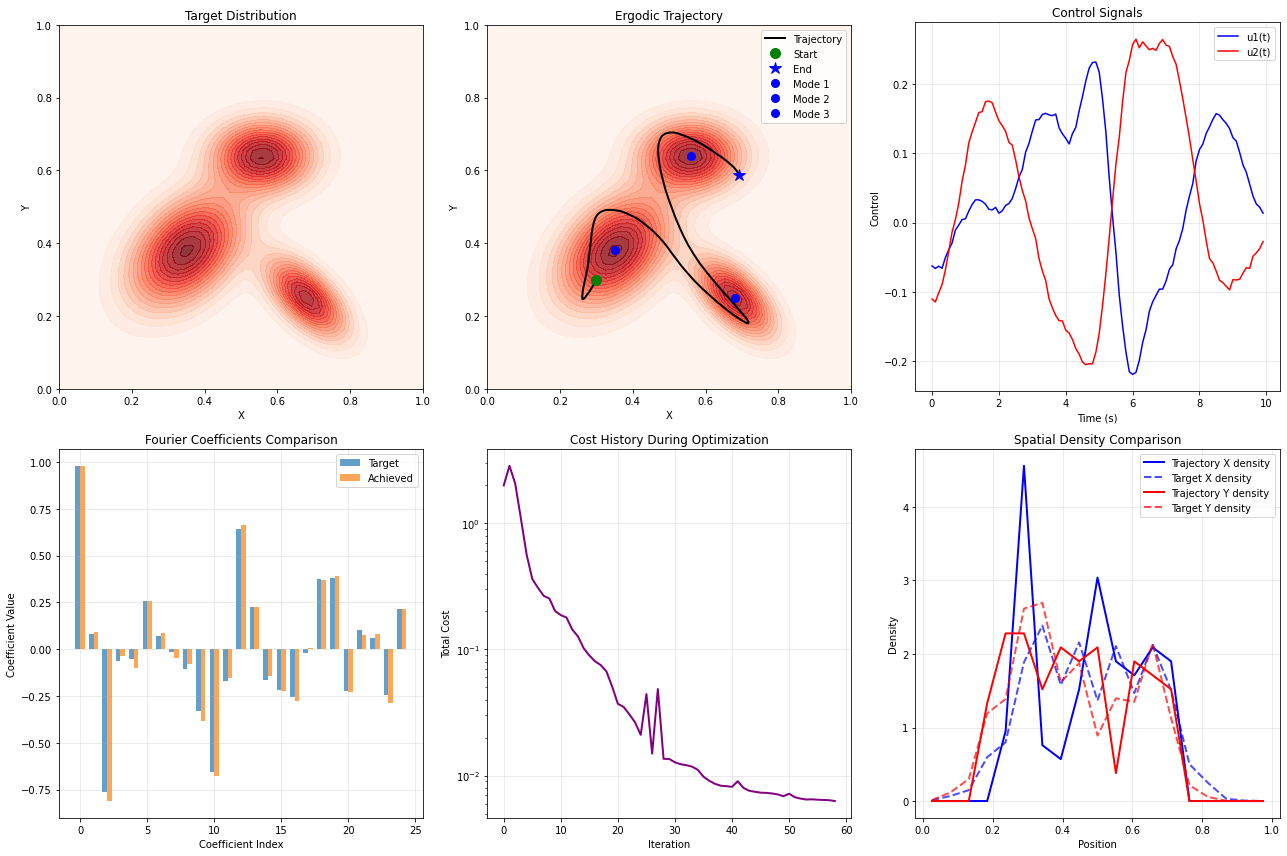


Control statistics:
u1 range: [-0.219, 0.232]
u2 range: [-0.205, 0.265]
Max |u|: 0.265
Ergodic metric: 0.001997
Cost reduction: 1.997932 -> 0.006288
Optimization converged in 59 iterations


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

# --- 1. GMM Parameters (same as notebook) ---
w = [0.5, 0.2, 0.3]
mu = [np.array([0.35, 0.38]), np.array([0.68, 0.25]), np.array([0.56, 0.64])]
Sigma = [
    np.array([[0.01, 0.004], [0.004, 0.01]]),
    np.array([[0.005, -0.003], [-0.003, 0.005]]),
    np.array([[0.008, 0.0], [0.0, 0.004]])
]
gaussians = [multivariate_normal(mean=m, cov=s) for m, s in zip(mu, Sigma)]

def pdf(x):
    """GMM probability density function"""
    if x.ndim == 1:
        x = x.reshape(1, -1)
    pdf_val = 0
    for weight, gauss in zip(w, gaussians):
        pdf_val += weight * gauss.pdf(x)
    return pdf_val

# --- 2. Fourier Basis Setup (following notebook exactly) ---
L_list = np.array([1.0, 1.0])  # Domain boundaries
num_k_per_dim = 5  # Reduced for stability
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T  # Index vectors

print(f"Using {ks.shape[0]} Fourier basis functions")

# --- 3. Target Distribution Coefficients (notebook method) ---
# Discretize the search space
grid_size = 50
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], grid_size),
    np.linspace(0, L_list[1], grid_size)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = dy = 1.0 / (grid_size - 1)

# Compute target coefficients using the notebook's exact method
coefficients = np.zeros(ks.shape[0])
for i, k_vec in enumerate(ks):
    # Evaluate fourier basis function over all grid cells
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)  # Normalization term
    fk_vals /= hk
    
    # Evaluate spatial probability density function over all grid cells
    pdf_vals = pdf(grids)
    
    # Approximate the integral through Riemann sum
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    coefficients[i] = phik

print(f"Target coefficients computed. First 5: {coefficients[:5]}")

# --- 4. Trajectory Optimization ---
dt = 0.1
T_horizon = 10.0
tlist = np.arange(0, T_horizon, dt)
N_steps = len(tlist)
x0 = np.array([0.3, 0.3])

def trajectory_from_controls(u_flat):
    """Convert flat control vector to trajectory"""
    u_traj = u_flat.reshape(N_steps, 2)
    x_traj = np.zeros((N_steps + 1, 2))
    x_traj[0] = x0.copy()
    
    for t in range(N_steps):
        x_next = x_traj[t] + dt * u_traj[t]
        x_traj[t+1] = np.clip(x_next, 0, 1)  # Keep in bounds
    
    return x_traj, u_traj

def calculate_trajectory_coefficients(x_traj):
    """Calculate trajectory coefficients using notebook method"""
    traj_coefficients = np.zeros(ks.shape[0])
    
    for i, k_vec in enumerate(ks):
        # Evaluate basis function over the trajectory
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * x_traj[:-1]), axis=1)
        hk = np.sqrt(np.sum(np.square(np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1))) * dx * dy)
        fk_vals /= hk
        
        # Approximate integral through Riemann sum
        ck = np.sum(fk_vals) * dt / (N_steps * dt)
        traj_coefficients[i] = ck
    
    return traj_coefficients

def ergodic_objective(u_flat):
    """Ergodic optimization objective following notebook"""
    x_traj, u_traj = trajectory_from_controls(u_flat)
    
    # Calculate trajectory coefficients
    traj_coeffs = calculate_trajectory_coefficients(x_traj)
    
    # Ergodic metric (following notebook exactly)
    lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
    erg_cost = np.sum(lamk_list * np.square(coefficients - traj_coeffs))
    
    # Light regularization
    ctrl_cost = 0.01 * np.sum(u_traj**2) * dt
    smooth_cost = 0.01 * np.sum(np.diff(u_traj, axis=0)**2)
    
    total_cost = erg_cost + ctrl_cost + smooth_cost
    
    return total_cost

def ergodic_gradient(u_flat):
    """Numerical gradient"""
    grad = np.zeros_like(u_flat)
    eps = 1e-6
    
    f0 = ergodic_objective(u_flat)
    
    for i in range(len(u_flat)):
        u_plus = u_flat.copy()
        u_plus[i] += eps
        f_plus = ergodic_objective(u_plus)
        grad[i] = (f_plus - f0) / eps
    
    return grad

# --- 5. Optimization ---
print("Starting ergodic trajectory optimization...")

# Initialize with small random controls
np.random.seed(42)
u_init = 0.05 * np.random.randn(N_steps * 2)

# Control bounds
bounds = [(-1.0, 1.0) for _ in range(N_steps * 2)]

# Track cost history during optimization
cost_history = []

def objective_with_history(u_flat):
    cost = ergodic_objective(u_flat)
    cost_history.append(cost)
    return cost

# Run optimization
result = minimize(
    objective_with_history,
    u_init,
    method='L-BFGS-B',
    jac=ergodic_gradient,
    bounds=bounds,
    options={'maxiter': 50, 'disp': True}
)

print(f"Optimization completed. Success: {result.success}")
print(f"Final cost: {result.fun:.6f}")
print(f"Total iterations: {len(cost_history)}")

# --- 6. Extract and Analyze Results ---
u_opt = result.x
x_final_traj, u_final_traj = trajectory_from_controls(u_opt)

# Calculate final ergodic performance
traj_coeffs_final = calculate_trajectory_coefficients(x_final_traj)
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
final_ergodic_metric = np.sum(lamk_list * np.square(coefficients - traj_coeffs_final))

print(f"\nFinal ergodic metric: {final_ergodic_metric:.6f}")
print("Target vs Final coefficients:")
for i, (k, phi, c) in enumerate(zip(ks[:10], coefficients[:10], traj_coeffs_final[:10])):
    print(f"  k={k}: target={phi:.4f}, achieved={c:.4f}, diff={c-phi:.4f}")

# --- 7. Visualization ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original PDF
ax = axes[0, 0]
pdf_vals = pdf(grids)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=20, cmap='Reds', alpha=0.8)
ax.set_title('Target Distribution')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

# Trajectory on PDF
ax = axes[0, 1]
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=20, cmap='Reds', alpha=0.8)
ax.plot(x_final_traj[:, 0], x_final_traj[:, 1], 'k-', lw=2, label='Trajectory')
ax.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
ax.plot(x_final_traj[-1, 0], x_final_traj[-1, 1], 'b*', markersize=12, label='End')
for i, mean in enumerate(mu):
    ax.plot(mean[0], mean[1], 'bo', markersize=8, label=f'Mode {i+1}')
ax.set_title('Ergodic Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.set_aspect('equal')

# Control signals
ax = axes[0, 2]
ax.plot(tlist, u_final_traj[:, 0], 'b-', lw=1.5, label='u1(t)')
ax.plot(tlist, u_final_traj[:, 1], 'r-', lw=1.5, label='u2(t)')
ax.set_title('Control Signals')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Control')
ax.legend()
ax.grid(True, alpha=0.3)

# Coefficient comparison
ax = axes[1, 0]
indices = np.arange(len(coefficients))
width = 0.35
ax.bar(indices - width/2, coefficients, width, label='Target', alpha=0.7)
ax.bar(indices + width/2, traj_coeffs_final, width, label='Achieved', alpha=0.7)
ax.set_title('Fourier Coefficients Comparison')
ax.set_xlabel('Coefficient Index')
ax.set_ylabel('Coefficient Value')
ax.legend()
ax.grid(True, alpha=0.3)

# PDF values along trajectory
ax = axes[1, 1]
if len(cost_history) > 1:
    ax.plot(range(len(cost_history)), cost_history, 'purple', lw=2)
    ax.set_title('Cost History During Optimization')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Total Cost')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # Log scale for better visualization
else:
    ax.text(0.5, 0.5, 'No cost history available', ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Cost History')

# Trajectory density comparison (both X and Y)
ax = axes[1, 2]
# Create density comparison for both dimensions
time_bins = np.linspace(0, 1, 20)

# X-direction densities
x_hist, _ = np.histogram(x_final_traj[:-1, 0], bins=time_bins, density=True)
x_target_hist, _ = np.histogram(grids[:, 0], bins=time_bins, weights=pdf_vals, density=True)

# Y-direction densities  
y_hist, _ = np.histogram(x_final_traj[:-1, 1], bins=time_bins, density=True)
y_target_hist, _ = np.histogram(grids[:, 1], bins=time_bins, weights=pdf_vals, density=True)

bin_centers = (time_bins[:-1] + time_bins[1:]) / 2

# Plot both dimensions
ax.plot(bin_centers, x_hist, 'b-', lw=2, label='Trajectory X density')
ax.plot(bin_centers, x_target_hist, 'b--', lw=2, alpha=0.7, label='Target X density')
ax.plot(bin_centers, y_hist, 'r-', lw=2, label='Trajectory Y density')
ax.plot(bin_centers, y_target_hist, 'r--', lw=2, alpha=0.7, label='Target Y density')

ax.set_title('Spatial Density Comparison')
ax.set_xlabel('Position')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final statistics
print(f"\nControl statistics:")
print(f"u1 range: [{np.min(u_final_traj[:, 0]):.3f}, {np.max(u_final_traj[:, 0]):.3f}]")
print(f"u2 range: [{np.min(u_final_traj[:, 1]):.3f}, {np.max(u_final_traj[:, 1]):.3f}]")
print(f"Max |u|: {np.max(np.abs(u_final_traj)):.3f}")

# Ergodic performance metrics
print(f"Ergodic metric: {final_ergodic_metric:.6f}")
if len(cost_history) > 1:
    print(f"Cost reduction: {cost_history[0]:.6f} -> {cost_history[-1]:.6f}")
    print(f"Optimization converged in {len(cost_history)} iterations")

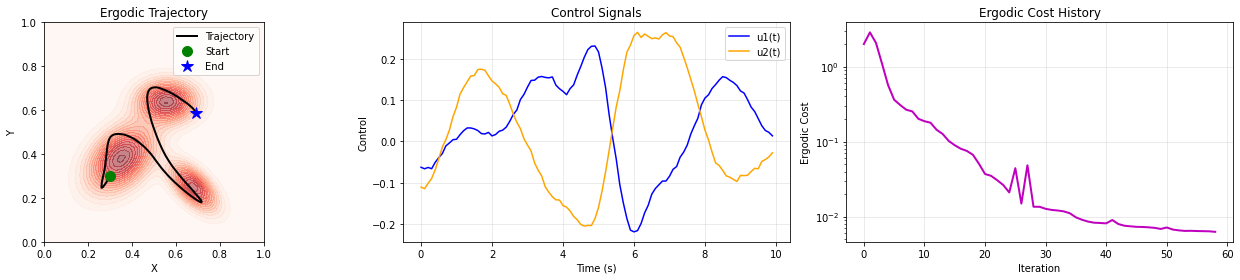

In [14]:
# --- Plot: Ergodic Trajectory, Control Signals, and Ergodic Cost History Only ---

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# 1. Ergodic Trajectory
ax = axes[0]
pdf_vals = pdf(grids)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=20, cmap='Reds', alpha=0.5)
ax.plot(x_final_traj[:, 0], x_final_traj[:, 1], 'k-', lw=2, label='Trajectory')
ax.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
ax.plot(x_final_traj[-1, 0], x_final_traj[-1, 1], 'b*', markersize=12, label='End')
ax.set_title('Ergodic Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.set_aspect('equal')

# 2. Control Signals
ax = axes[1]
ax.plot(tlist, u_final_traj[:, 0], color='blue', lw=1.5, label='u1(t)')
ax.plot(tlist, u_final_traj[:, 1], color='orange', lw=1.5, label='u2(t)')
ax.set_title('Control Signals')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Control')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Ergodic Cost History
ax = axes[2]
if len(cost_history) > 1:
    ax.plot(range(len(cost_history)), cost_history, color='m', lw=2)
    ax.set_title('Ergodic Cost History')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Ergodic Cost')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
else:
    ax.axhline(final_ergodic_metric, color='m', lw=2, label='Final Ergodic Cost')
    ax.set_title('Ergodic Cost')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Ergodic Cost')
    ax.legend()

plt.tight_layout()
plt.show()

Using 16 Fourier basis functions
Target coefficients computed. First 5: [ 0.9798801   0.0787666  -0.76391984 -0.06205444  0.25776273]
Starting improved second-order ergodic trajectory optimization...
  Iteration 20: Cost = 1.538997, Ergodic = 0.016858
  Iteration 40: Cost = 0.407891, Ergodic = 0.005281
  Iteration 60: Cost = 0.138175, Ergodic = 0.002681
  Iteration 80: Cost = -0.016186, Ergodic = 0.001813
  Iteration 100: Cost = -0.035144, Ergodic = 0.001722
  Iteration 120: Cost = -0.025339, Ergodic = 0.001720
  Iteration 140: Cost = -0.025336, Ergodic = 0.001720
  Iteration 160: Cost = -0.026705, Ergodic = 0.001707
  Iteration 180: Cost = -0.036192, Ergodic = 0.001712
  Iteration 200: Cost = -0.026192, Ergodic = 0.001712
Optimization completed. Success: False
Final cost: -0.036192
Total iterations: 208

Final ergodic metric: 0.001712
Target vs Final coefficients:
  k=[0 0]: target=0.9799, achieved=0.9800, diff=0.0001
  k=[1 0]: target=0.0788, achieved=0.0814, diff=0.0026
  k=[2 0]: t

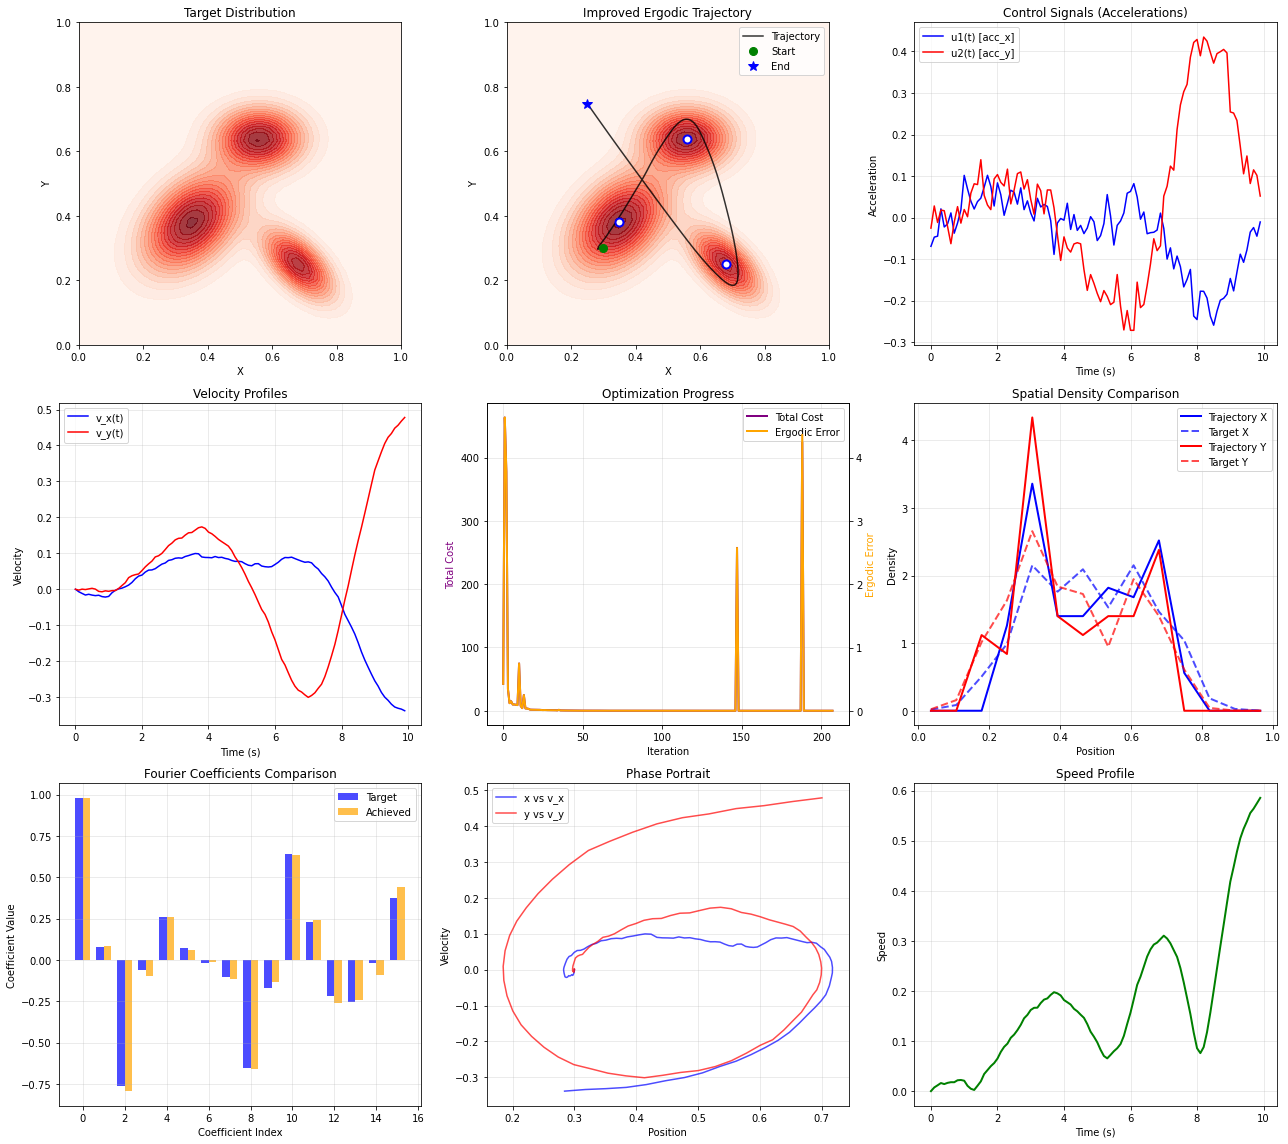


COMPREHENSIVE RESULTS

Control Statistics:
  u1 range: [-0.259, 0.102]
  u2 range: [-0.272, 0.435]
  Max |u|: 0.435

Dynamics Statistics:
  Max speed: 0.585
  Average speed: 0.177
  Total distance: 1.773

Ergodic Performance:
  Final ergodic metric: 0.001712
  Average coefficient error: 0.021520

Optimization:
  Cost reduction: 42.433715 -> -0.036192
  Ergodic improvement: 0.426176 -> 0.001712
  Iterations: 208

Spatial Coverage:
  Visited 23/100 grid cells (23.0%)


In [9]:

# --- 1. GMM Parameters (same as before) ---
w = [0.5, 0.2, 0.3]
mu = [np.array([0.35, 0.38]), np.array([0.68, 0.25]), np.array([0.56, 0.64])]
Sigma = [
    np.array([[0.01, 0.004], [0.004, 0.01]]),
    np.array([[0.005, -0.003], [-0.003, 0.005]]),
    np.array([[0.008, 0.0], [0.0, 0.004]])
]
gaussians = [multivariate_normal(mean=m, cov=s) for m, s in zip(mu, Sigma)]

def pdf(x):
    """GMM probability density function"""
    if x.ndim == 1:
        x = x.reshape(1, -1)
    pdf_val = 0
    for weight, gauss in zip(w, gaussians):
        pdf_val += weight * gauss.pdf(x)
    return pdf_val

# --- 2. Fourier Basis Setup ---
L_list = np.array([1.0, 1.0])
num_k_per_dim = 4  # Reduced further for better optimization
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T

print(f"Using {ks.shape[0]} Fourier basis functions")

# --- 3. Target Distribution Coefficients ---
grid_size = 50
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], grid_size),
    np.linspace(0, L_list[1], grid_size)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = dy = 1.0 / (grid_size - 1)

# Compute target coefficients
coefficients = np.zeros(ks.shape[0])
for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    fk_vals /= hk
    
    pdf_vals = pdf(grids)
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    coefficients[i] = phik

print(f"Target coefficients computed. First 5: {coefficients[:5]}")

# --- 4. Improved Second-Order System ---
dt = 0.1
T_horizon = 10.0 
tlist = np.arange(0, T_horizon, dt)
N_steps = len(tlist)

# Initial conditions: [x1, x2, x1_dot, x2_dot]
x0 = np.array([0.3, 0.3, 0.0, 0.0])  # Start at center

def trajectory_from_controls(u_flat):
    """
    Second-order system with improved boundary handling
    """
    u_traj = u_flat.reshape(N_steps, 2)
    
    # State trajectory: [x1, x2, x1_dot, x2_dot]
    state_traj = np.zeros((N_steps + 1, 4))
    state_traj[0] = x0.copy()
    
    for t in range(N_steps):
        # Current state
        pos = state_traj[t, :2]
        vel = state_traj[t, 2:]
        
        # Control input with damping near boundaries
        acc = u_traj[t].copy()
        
        # Add boundary damping to prevent chaotic reflections
        boundary_margin = 0.1
        damping_factor = 0.5
        
        for i in range(2):
            if pos[i] < boundary_margin:
                # Near left/bottom boundary
                if vel[i] < 0:  # Moving toward boundary
                    acc[i] += damping_factor * abs(vel[i])
            elif pos[i] > (1.0 - boundary_margin):
                # Near right/top boundary  
                if vel[i] > 0:  # Moving toward boundary
                    acc[i] -= damping_factor * abs(vel[i])
        
        # Integrate dynamics
        pos_new = pos + vel * dt + 0.5 * acc * dt**2
        vel_new = vel + acc * dt
        
        # Soft boundary constraints with damping
        for i in range(2):
            if pos_new[i] < 0:
                pos_new[i] = 0
                vel_new[i] = max(0, vel_new[i])  # Only allow outward velocity
            elif pos_new[i] > 1:
                pos_new[i] = 1
                vel_new[i] = min(0, vel_new[i])  # Only allow inward velocity
        
        state_traj[t+1] = np.concatenate([pos_new, vel_new])
    
    pos_traj = state_traj[:, :2]
    return pos_traj, state_traj, u_traj

def calculate_trajectory_coefficients(pos_traj):
    """Calculate trajectory coefficients with proper weighting"""
    traj_coefficients = np.zeros(ks.shape[0])
    
    for i, k_vec in enumerate(ks):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * pos_traj[:-1]), axis=1)
        hk = np.sqrt(np.sum(np.square(np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1))) * dx * dy)
        fk_vals /= hk
        
        # Weighted average over time
        ck = np.mean(fk_vals)
        traj_coefficients[i] = ck
    
    return traj_coefficients

def ergodic_objective(u_flat):
    """Improved objective function with better cost balance"""
    pos_traj, state_traj, u_traj = trajectory_from_controls(u_flat)
    
    # Calculate trajectory coefficients
    traj_coeffs = calculate_trajectory_coefficients(pos_traj)
    
    # Ergodic metric with higher weight
    lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
    erg_cost = np.sum(lamk_list * np.square(coefficients - traj_coeffs))
    
    # Control effort - light penalty
    ctrl_cost = 0.01 * np.sum(u_traj**2) * dt
    
    # Smoothness - prevent sudden changes
    smooth_cost = 0.05 * np.sum(np.diff(u_traj, axis=0)**2)
    
    # Speed limit - prevent excessive velocities
    speeds = np.sqrt(state_traj[:-1, 2]**2 + state_traj[:-1, 3]**2)
    speed_penalty = 0.1 * np.sum(np.maximum(0, speeds - 1.0)**2) * dt
    
    # Exploration bonus - reward visiting different regions
    exploration_bonus = 0.0
    grid_resolution = 10
    visited_cells = set()
    for pos in pos_traj[:-1]:
        cell_x = int(pos[0] * grid_resolution)
        cell_y = int(pos[1] * grid_resolution)
        cell_x = max(0, min(grid_resolution-1, cell_x))
        cell_y = max(0, min(grid_resolution-1, cell_y))
        visited_cells.add((cell_x, cell_y))
    
    exploration_bonus = -0.01 * len(visited_cells)  # Reward diversity
    
    total_cost = 100.0 * erg_cost + ctrl_cost + smooth_cost + speed_penalty + exploration_bonus
    
    return total_cost

def ergodic_gradient(u_flat):
    """Numerical gradient with adaptive step size"""
    grad = np.zeros_like(u_flat)
    eps = 1e-5
    
    f0 = ergodic_objective(u_flat)
    
    # Compute gradient in blocks for efficiency
    block_size = 20
    for start_idx in range(0, len(u_flat), block_size):
        end_idx = min(start_idx + block_size, len(u_flat))
        for i in range(start_idx, end_idx):
            u_plus = u_flat.copy()
            u_plus[i] += eps
            f_plus = ergodic_objective(u_plus)
            grad[i] = (f_plus - f0) / eps
    
    return grad

# --- 5. Optimization with Better Strategy ---
print("Starting improved second-order ergodic trajectory optimization...")

# Initialize with smoother controls
np.random.seed(42)
u_init = 0.05 * np.random.randn(N_steps * 2)

# Add some structure to initial guess - oscillatory motion
for i in range(N_steps):
    t = i * dt
    u_init[2*i] += 0.1 * np.sin(2 * np.pi * t / T_horizon)      # x acceleration
    u_init[2*i+1] += 0.1 * np.cos(2 * np.pi * t / T_horizon)    # y acceleration

# Tighter control bounds for smoother motion
bounds = [(-0.5, 0.5) for _ in range(N_steps * 2)]

# Track cost history
cost_history = []
ergodic_history = []

def objective_with_history(u_flat):
    cost = ergodic_objective(u_flat)
    cost_history.append(cost)
    
    # Calculate ergodic component for tracking
    pos_traj, _, _ = trajectory_from_controls(u_flat)
    traj_coeffs = calculate_trajectory_coefficients(pos_traj)
    lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
    erg_metric = np.sum(lamk_list * np.square(coefficients - traj_coeffs))
    ergodic_history.append(erg_metric)
    
    if len(cost_history) % 20 == 0:
        print(f"  Iteration {len(cost_history)}: Cost = {cost:.6f}, Ergodic = {erg_metric:.6f}")
    return cost

# Run optimization with different strategy
result = minimize(
    objective_with_history,
    u_init,
    method='L-BFGS-B',
    jac=ergodic_gradient,
    bounds=bounds,
    options={
        'maxiter': 200, 
        'disp': True,
        'ftol': 1e-8,
        'gtol': 1e-6
    }
)

print(f"Optimization completed. Success: {result.success}")
print(f"Final cost: {result.fun:.6f}")
print(f"Total iterations: {len(cost_history)}")

# --- 6. Extract and Analyze Results ---
u_opt = result.x
pos_final, state_final, u_final = trajectory_from_controls(u_opt)

# Calculate final ergodic performance
traj_coeffs_final = calculate_trajectory_coefficients(pos_final)
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
final_ergodic_metric = np.sum(lamk_list * np.square(coefficients - traj_coeffs_final))

print(f"\nFinal ergodic metric: {final_ergodic_metric:.6f}")
print("Target vs Final coefficients:")
for i, (k, phi, c) in enumerate(zip(ks, coefficients, traj_coeffs_final)):
    print(f"  k={k}: target={phi:.4f}, achieved={c:.4f}, diff={abs(c-phi):.4f}")

# --- 7. Enhanced Visualization ---
fig, axes = plt.subplots(3, 3, figsize=(18, 16))

# Target distribution
ax = axes[0, 0]
pdf_vals = pdf(grids)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=20, cmap='Reds', alpha=0.8)
ax.set_title('Target Distribution')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

# Trajectory on PDF
ax = axes[0, 1]
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=20, cmap='Reds', alpha=0.8)
ax.plot(pos_final[:, 0], pos_final[:, 1], 'k-', lw=1.5, alpha=0.8, label='Trajectory')
ax.plot(x0[0], x0[1], 'go', markersize=8, label='Start')
ax.plot(pos_final[-1, 0], pos_final[-1, 1], 'b*', markersize=10, label='End')

# Add mode locations
for i, mean in enumerate(mu):
    ax.plot(mean[0], mean[1], 'wo', markersize=8, markeredgecolor='blue', markeredgewidth=2)

ax.set_title('Improved Ergodic Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.set_aspect('equal')

# Control signals
ax = axes[0, 2]
ax.plot(tlist, u_final[:, 0], 'b-', lw=1.5, label='u1(t) [acc_x]')
ax.plot(tlist, u_final[:, 1], 'r-', lw=1.5, label='u2(t) [acc_y]')
ax.set_title('Control Signals (Accelerations)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Acceleration')
ax.legend()
ax.grid(True, alpha=0.3)

# Velocity profiles
ax = axes[1, 0]
ax.plot(tlist, state_final[:-1, 2], 'b-', lw=1.5, label='v_x(t)')
ax.plot(tlist, state_final[:-1, 3], 'r-', lw=1.5, label='v_y(t)')
ax.set_title('Velocity Profiles')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity')
ax.legend()
ax.grid(True, alpha=0.3)

# Cost and ergodic history
ax = axes[1, 1]
if len(cost_history) > 1:
    ax2 = ax.twinx()
    line1 = ax.plot(range(len(cost_history)), cost_history, 'purple', lw=2, label='Total Cost')
    line2 = ax2.plot(range(len(ergodic_history)), ergodic_history, 'orange', lw=2, label='Ergodic Error')
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Total Cost', color='purple')
    ax2.set_ylabel('Ergodic Error', color='orange')
    ax.set_title('Optimization Progress')
    ax.grid(True, alpha=0.3)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper right')

# Spatial density comparison
ax = axes[1, 2]
time_bins = np.linspace(0, 1, 15)

x_hist, _ = np.histogram(pos_final[:-1, 0], bins=time_bins, density=True)
x_target_hist, _ = np.histogram(grids[:, 0], bins=time_bins, weights=pdf_vals, density=True)
y_hist, _ = np.histogram(pos_final[:-1, 1], bins=time_bins, density=True)
y_target_hist, _ = np.histogram(grids[:, 1], bins=time_bins, weights=pdf_vals, density=True)

bin_centers = (time_bins[:-1] + time_bins[1:]) / 2

ax.plot(bin_centers, x_hist, 'b-', lw=2, label='Trajectory X')
ax.plot(bin_centers, x_target_hist, 'b--', lw=2, alpha=0.7, label='Target X')
ax.plot(bin_centers, y_hist, 'r-', lw=2, label='Trajectory Y')
ax.plot(bin_centers, y_target_hist, 'r--', lw=2, alpha=0.7, label='Target Y')

ax.set_title('Spatial Density Comparison')
ax.set_xlabel('Position')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

# Coefficient comparison
ax = axes[2, 0]
indices = np.arange(len(coefficients))
width = 0.35
ax.bar(indices - width/2, coefficients, width, label='Target', alpha=0.7, color='blue')
ax.bar(indices + width/2, traj_coeffs_final, width, label='Achieved', alpha=0.7, color='orange')
ax.set_title('Fourier Coefficients Comparison')
ax.set_xlabel('Coefficient Index')
ax.set_ylabel('Coefficient Value')
ax.legend()
ax.grid(True, alpha=0.3)

# Phase portrait
ax = axes[2, 1]
ax.plot(state_final[:-1, 0], state_final[:-1, 2], 'b-', lw=1.5, alpha=0.7, label='x vs v_x')
ax.plot(state_final[:-1, 1], state_final[:-1, 3], 'r-', lw=1.5, alpha=0.7, label='y vs v_y')
ax.set_title('Phase Portrait')
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.legend()
ax.grid(True, alpha=0.3)

# Speed and exploration
ax = axes[2, 2]
speed = np.sqrt(state_final[:-1, 2]**2 + state_final[:-1, 3]**2)
ax.plot(tlist, speed, 'g-', lw=2)
ax.set_title('Speed Profile')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Speed')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final comprehensive statistics
print(f"\n{'='*50}")
print(f"COMPREHENSIVE RESULTS")
print(f"{'='*50}")

print(f"\nControl Statistics:")
print(f"  u1 range: [{np.min(u_final[:, 0]):.3f}, {np.max(u_final[:, 0]):.3f}]")
print(f"  u2 range: [{np.min(u_final[:, 1]):.3f}, {np.max(u_final[:, 1]):.3f}]")
print(f"  Max |u|: {np.max(np.abs(u_final)):.3f}")

print(f"\nDynamics Statistics:")
print(f"  Max speed: {np.max(speed):.3f}")
print(f"  Average speed: {np.mean(speed):.3f}")
print(f"  Total distance: {np.sum(speed) * dt:.3f}")

print(f"\nErgodic Performance:")
print(f"  Final ergodic metric: {final_ergodic_metric:.6f}")
print(f"  Average coefficient error: {np.mean(np.abs(coefficients - traj_coeffs_final)):.6f}")

if len(cost_history) > 1:
    print(f"\nOptimization:")
    print(f"  Cost reduction: {cost_history[0]:.6f} -> {cost_history[-1]:.6f}")
    print(f"  Ergodic improvement: {ergodic_history[0]:.6f} -> {ergodic_history[-1]:.6f}")
    print(f"  Iterations: {len(cost_history)}")

# Coverage analysis
grid_resolution = 10
visited_cells = set()
for pos in pos_final[:-1]:
    cell_x = int(pos[0] * grid_resolution)
    cell_y = int(pos[1] * grid_resolution)
    cell_x = max(0, min(grid_resolution-1, cell_x))
    cell_y = max(0, min(grid_resolution-1, cell_y))
    visited_cells.add((cell_x, cell_y))

coverage_percent = len(visited_cells) / (grid_resolution**2) * 100
print(f"\nSpatial Coverage:")
print(f"  Visited {len(visited_cells)}/{grid_resolution**2} grid cells ({coverage_percent:.1f}%)")

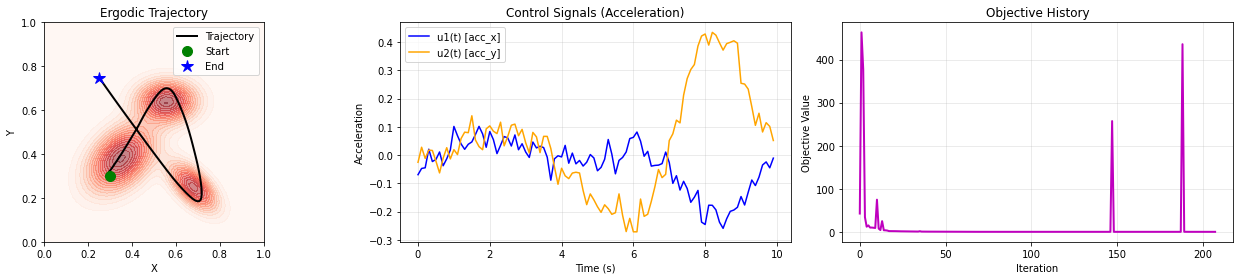

In [13]:
# --- Plot: Ergodic Trajectory, Control Signals (Acceleration), and Objective History Only ---

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# 1. Ergodic Trajectory
ax = axes[0]
pdf_vals = pdf(grids)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=20, cmap='Reds', alpha=0.5)
ax.plot(pos_final[:, 0], pos_final[:, 1], 'k-', lw=2, label='Trajectory')
ax.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
ax.plot(pos_final[-1, 0], pos_final[-1, 1], 'b*', markersize=12, label='End')
ax.set_title('Ergodic Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.set_aspect('equal')

# 2. Control Signals (Acceleration)
ax = axes[1]
ax.plot(tlist, u_final[:, 0], color='blue', lw=1.5, label='u1(t) [acc_x]')
ax.plot(tlist, u_final[:, 1], color='orange', lw=1.5, label='u2(t) [acc_y]')
ax.set_title('Control Signals (Acceleration)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Acceleration')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Objective (Cost) History
ax = axes[2]
if len(cost_history) > 1:
    ax.plot(range(len(cost_history)), cost_history, color='m', lw=2)
    ax.set_title('Objective History')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Objective Value')
    ax.grid(True, alpha=0.3)
else:
    ax.axhline(final_ergodic_metric, color='m', lw=2, label='Final Objective')
    ax.set_title('Objective Value')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Objective Value')
    ax.legend()

plt.tight_layout()
plt.show()

Using 16 Fourier basis functions
Target coefficients computed. First 5: [ 0.9798801   0.0787666  -0.76391984 -0.06205444  0.25776273]
Starting improved differential-drive ergodic optimization...
  Iter 25: Cost=4.500, Erg=0.1144, Dist=6.19m, Cov=38.0%
  Iter 50: Cost=4.501, Erg=0.1144, Dist=6.19m, Cov=38.0%
Optimization completed. Success: False
Final cost: 4.460361
Total iterations: 55

Final ergodic metric: 0.114469


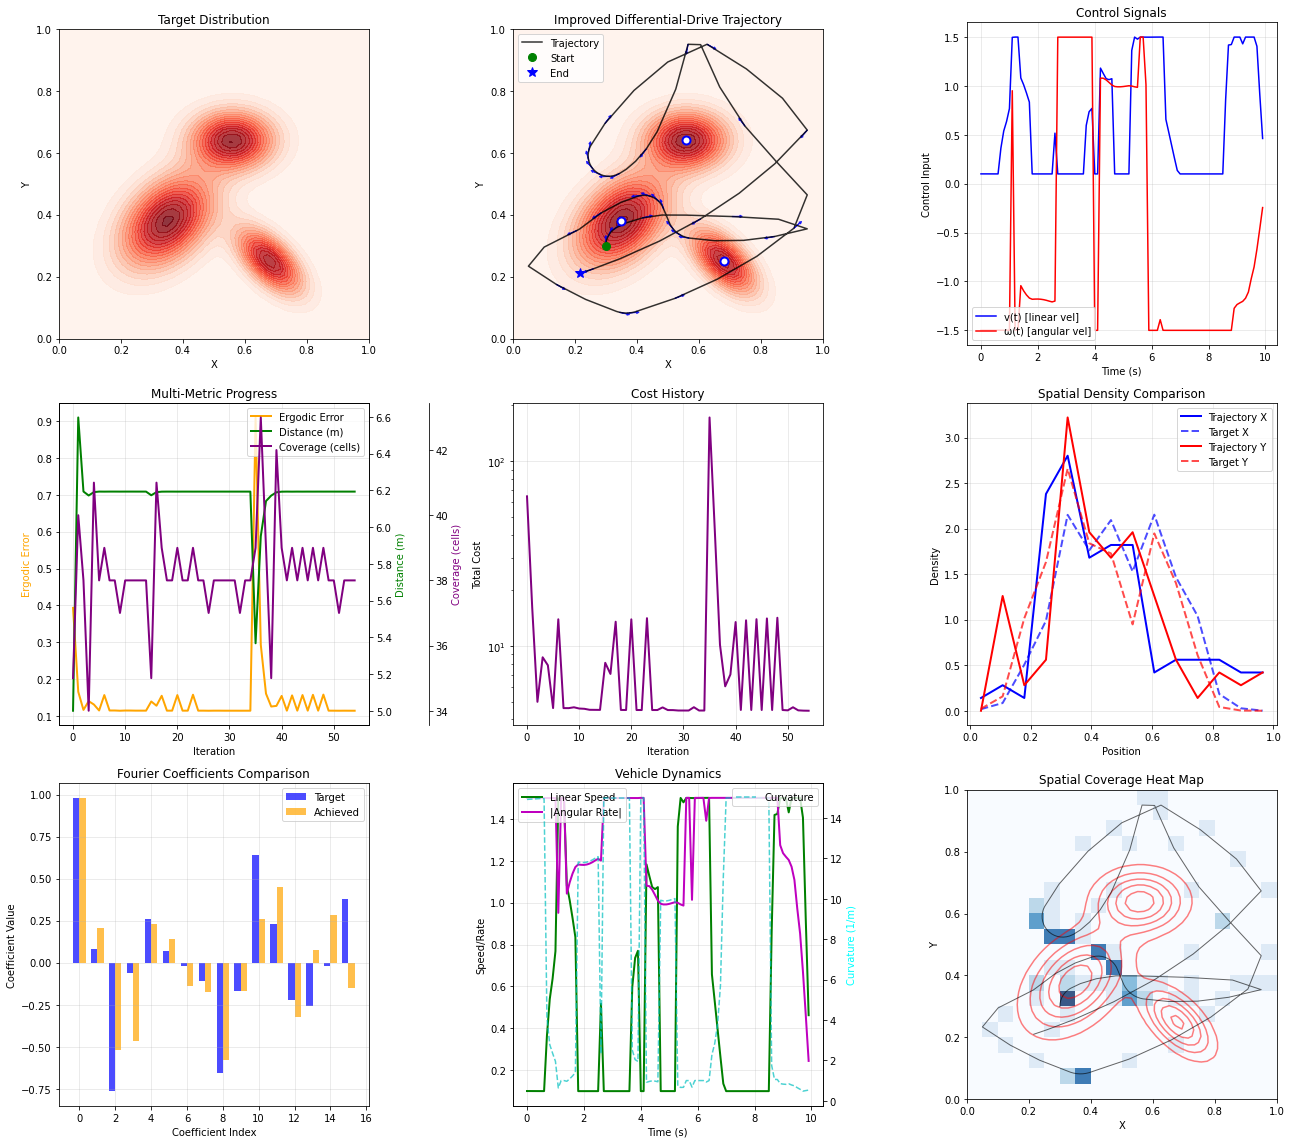


IMPROVED DIFFERENTIAL-DRIVE RESULTS

Control Statistics:
  Linear velocity range: [0.100, 1.500] m/s
  Angular velocity range: [-1.500, 1.500] rad/s
  Average speed: 0.619 m/s

Vehicle Motion:
  Total distance traveled: 6.193 m
  Average curvature: 7.592 1/m
  Max curvature: 15.000 1/m

Ergodic Performance:
  Final ergodic metric: 0.114469
  Average coefficient error: 0.187615

Spatial Coverage:
  Visited 38/100 grid cells (38.0%)

Optimization:
  Cost reduction: 64.430 -> 4.460
  Ergodic improvement: 0.393306 -> 0.114263
  Distance improvement: 5.00 -> 6.19 m
  Coverage improvement: 35 -> 38 cells
  Iterations: 55

Trajectory Quality:
  Start: x=0.300, y=0.300, θ=90.0°
  End:   x=0.216, y=0.210, θ=-161.9°
  Smoothness: Avg vel change = 0.127
  Smoothness: Avg ω change = 0.191


In [14]:
# --- 1. GMM Parameters (same as before) ---
w = [0.5, 0.2, 0.3]
mu = [np.array([0.35, 0.38]), np.array([0.68, 0.25]), np.array([0.56, 0.64])]
Sigma = [
    np.array([[0.01, 0.004], [0.004, 0.01]]),
    np.array([[0.005, -0.003], [-0.003, 0.005]]),
    np.array([[0.008, 0.0], [0.0, 0.004]])
]
gaussians = [multivariate_normal(mean=m, cov=s) for m, s in zip(mu, Sigma)]

def pdf(x):
    """GMM probability density function"""
    if x.ndim == 1:
        x = x.reshape(1, -1)
    pdf_val = 0
    for weight, gauss in zip(w, gaussians):
        pdf_val += weight * gauss.pdf(x)
    return pdf_val

# --- 2. Fourier Basis Setup ---
L_list = np.array([1.0, 1.0])
num_k_per_dim = 4
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T

print(f"Using {ks.shape[0]} Fourier basis functions")

# --- 3. Target Distribution Coefficients ---
grid_size = 50
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], grid_size),
    np.linspace(0, L_list[1], grid_size)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = dy = 1.0 / (grid_size - 1)

# Compute target coefficients
coefficients = np.zeros(ks.shape[0])
for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    fk_vals /= hk
    
    pdf_vals = pdf(grids)
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    coefficients[i] = phik

print(f"Target coefficients computed. First 5: {coefficients[:5]}")

# --- 4. Improved Differential-Drive Vehicle ---
dt = 0.1
T_horizon = 10.0
tlist = np.arange(0, T_horizon, dt)
N_steps = len(tlist)

# Initial conditions: [x, y, theta]
x0 = np.array([0.3, 0.3, np.pi/2])

def trajectory_from_controls(u_flat):
    """
    Improved differential-drive with better boundary handling
    """
    u_traj = u_flat.reshape(N_steps, 2)
    
    # State trajectory: [x, y, theta]
    state_traj = np.zeros((N_steps + 1, 3))
    state_traj[0] = x0.copy()
    
    for t in range(N_steps):
        # Current state
        x, y, theta = state_traj[t]
        
        # Control inputs
        v, omega = u_traj[t]
        
        # Ensure positive velocity
        v = max(0.01, v)  # Minimum forward speed
        
        # Integrate with improved method
        theta_mid = theta + 0.5 * omega * dt
        
        x_new = x + v * np.cos(theta_mid) * dt
        y_new = y + v * np.sin(theta_mid) * dt
        theta_new = theta + omega * dt
        
        # Normalize angle
        theta_new = np.arctan2(np.sin(theta_new), np.cos(theta_new))
        
        # IMPROVED: Smooth boundary handling (no sharp reflections)
        margin = 0.05
        
        # X boundary handling
        if x_new < margin:
            # Smooth turn away from boundary
            x_new = margin
            if np.cos(theta_new) < 0:  # Heading toward boundary
                theta_new = np.pi - theta_new  # Reflect heading
        elif x_new > (1.0 - margin):
            x_new = 1.0 - margin
            if np.cos(theta_new) > 0:  # Heading toward boundary
                theta_new = np.pi - theta_new
        
        # Y boundary handling  
        if y_new < margin:
            y_new = margin
            if np.sin(theta_new) < 0:  # Heading toward boundary
                theta_new = -theta_new
        elif y_new > (1.0 - margin):
            y_new = 1.0 - margin
            if np.sin(theta_new) > 0:  # Heading toward boundary
                theta_new = -theta_new
        
        # Normalize angle after boundary corrections
        theta_new = np.arctan2(np.sin(theta_new), np.cos(theta_new))
        
        state_traj[t+1] = np.array([x_new, y_new, theta_new])
    
    pos_traj = state_traj[:, :2]
    return pos_traj, state_traj, u_traj

def calculate_trajectory_coefficients(pos_traj):
    """Calculate trajectory coefficients using position data only"""
    traj_coefficients = np.zeros(ks.shape[0])
    
    for i, k_vec in enumerate(ks):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * pos_traj[:-1]), axis=1)
        hk = np.sqrt(np.sum(np.square(np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1))) * dx * dy)
        fk_vals /= hk
        
        ck = np.mean(fk_vals)
        traj_coefficients[i] = ck
    
    return traj_coefficients

def ergodic_objective(u_flat):
    """IMPROVED: Better balanced objective function"""
    pos_traj, state_traj, u_traj = trajectory_from_controls(u_flat)
    
    # Calculate trajectory coefficients
    traj_coeffs = calculate_trajectory_coefficients(pos_traj)
    
    # Ergodic metric - INCREASED WEIGHT
    lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
    erg_cost = np.sum(lamk_list * np.square(coefficients - traj_coeffs))
    
    # Control penalties - REDUCED to encourage exploration
    v_vals = u_traj[:, 0]
    omega_vals = u_traj[:, 1]
    
    # Light velocity penalty
    vel_penalty = 0.001 * np.sum(v_vals**2) * dt
    
    # Moderate angular penalty  
    omega_penalty = 0.005 * np.sum(omega_vals**2) * dt
    
    # Smoothness penalties - prevent jerky motion
    vel_smooth = 0.01 * np.sum(np.diff(v_vals)**2)
    omega_smooth = 0.02 * np.sum(np.diff(omega_vals)**2)
    
    # IMPROVED: Distance reward - encourage movement
    total_distance = np.sum(v_vals) * dt
    distance_reward = -0.1 * total_distance  # Negative = reward
    
    # IMPROVED: Coverage reward
    grid_resolution = 10
    visited_cells = set()
    for pos in pos_traj[:-1]:
        cell_x = int(pos[0] * grid_resolution)
        cell_y = int(pos[1] * grid_resolution)
        cell_x = max(0, min(grid_resolution-1, cell_x))
        cell_y = max(0, min(grid_resolution-1, cell_y))
        visited_cells.add((cell_x, cell_y))
    
    coverage_reward = -0.2 * len(visited_cells)  # Reward diversity
    
    # IMPROVED: PDF coverage reward
    pdf_reward = 0.0
    for pos in pos_traj[:-1]:
        pdf_val = pdf(pos)
        pdf_reward -= 0.5 * pdf_val * dt  # Reward visiting high-density areas
    
    # Balanced total cost
    total_cost = (200.0 * erg_cost +           # Strong ergodic emphasis
                  vel_penalty + omega_penalty +  # Light control penalties
                  vel_smooth + omega_smooth +     # Smoothness
                  distance_reward +               # Encourage movement
                  coverage_reward +               # Encourage exploration
                  pdf_reward)                     # Encourage visiting targets
    
    return total_cost

def ergodic_gradient(u_flat):
    """Numerical gradient with adaptive step size"""
    grad = np.zeros_like(u_flat)
    eps = 1e-5
    
    f0 = ergodic_objective(u_flat)
    
    for i in range(len(u_flat)):
        u_plus = u_flat.copy()
        u_plus[i] += eps
        f_plus = ergodic_objective(u_plus)
        grad[i] = (f_plus - f0) / eps
    
    return grad

# --- 5. IMPROVED Optimization Strategy ---
print("Starting improved differential-drive ergodic optimization...")

# Better initialization strategy
np.random.seed(42)
u_init = np.zeros(N_steps * 2)

# Create exploration-focused initial trajectory
# Use multiple frequency components for better coverage
for i in range(N_steps):
    t = i * dt
    
    # Higher base velocity for better exploration
    base_vel = 0.5
    vel_var = 0.3 * (np.sin(2 * np.pi * t / T_horizon) + 
                     0.5 * np.sin(6 * np.pi * t / T_horizon))
    u_init[2*i] = base_vel + vel_var
    
    # Multi-frequency angular velocity for complex patterns
    omega_base = np.sin(4 * np.pi * t / T_horizon)
    omega_high = 0.3 * np.sin(12 * np.pi * t / T_horizon)
    u_init[2*i+1] = omega_base + omega_high

# IMPROVED: Better control bounds
bounds = []
for i in range(N_steps):
    bounds.append((0.1, 1.5))     # Linear velocity: higher max for exploration
    bounds.append((-1.5, 1.5))   # Angular velocity: reasonable range

# Track optimization progress
cost_history = []
ergodic_history = []
distance_history = []
coverage_history = []

def objective_with_history(u_flat):
    cost = ergodic_objective(u_flat)
    cost_history.append(cost)
    
    # Calculate metrics for tracking
    pos_traj, state_traj, u_traj = trajectory_from_controls(u_flat)
    
    # Ergodic metric
    traj_coeffs = calculate_trajectory_coefficients(pos_traj)
    lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
    erg_metric = np.sum(lamk_list * np.square(coefficients - traj_coeffs))
    ergodic_history.append(erg_metric)
    
    # Distance traveled
    distance = np.sum(u_traj[:, 0]) * dt
    distance_history.append(distance)
    
    # Coverage
    grid_resolution = 10
    visited_cells = set()
    for pos in pos_traj[:-1]:
        cell_x = int(pos[0] * grid_resolution)
        cell_y = int(pos[1] * grid_resolution)
        cell_x = max(0, min(grid_resolution-1, cell_x))
        cell_y = max(0, min(grid_resolution-1, cell_y))
        visited_cells.add((cell_x, cell_y))
    coverage_history.append(len(visited_cells))
    
    if len(cost_history) % 25 == 0:
        coverage_pct = len(visited_cells) / (grid_resolution**2) * 100
        print(f"  Iter {len(cost_history)}: Cost={cost:.3f}, Erg={erg_metric:.4f}, "
              f"Dist={distance:.2f}m, Cov={coverage_pct:.1f}%")
    
    return cost

# Run optimization with better settings
result = minimize(
    objective_with_history,
    u_init,
    method='L-BFGS-B',
    jac=ergodic_gradient,
    bounds=bounds,
    options={
        'maxiter': 200,  # More iterations
        'disp': True,
        'ftol': 1e-9,    # Tighter tolerance
        'gtol': 1e-7
    }
)

print(f"Optimization completed. Success: {result.success}")
print(f"Final cost: {result.fun:.6f}")
print(f"Total iterations: {len(cost_history)}")

# --- 6. Extract and Analyze Results ---
u_opt = result.x
pos_final, state_final, u_final = trajectory_from_controls(u_opt)

# Calculate final ergodic performance
traj_coeffs_final = calculate_trajectory_coefficients(pos_final)
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
final_ergodic_metric = np.sum(lamk_list * np.square(coefficients - traj_coeffs_final))

print(f"\nFinal ergodic metric: {final_ergodic_metric:.6f}")

# --- 7. Enhanced Visualization ---
fig, axes = plt.subplots(3, 3, figsize=(18, 16))

# Target distribution
ax = axes[0, 0]
pdf_vals = pdf(grids)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=20, cmap='Reds', alpha=0.8)
ax.set_title('Target Distribution')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

# Trajectory with heading arrows
ax = axes[0, 1]
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=20, cmap='Reds', alpha=0.8)
ax.plot(pos_final[:, 0], pos_final[:, 1], 'k-', lw=1.5, alpha=0.8, label='Trajectory')
ax.plot(x0[0], x0[1], 'go', markersize=8, label='Start')
ax.plot(pos_final[-1, 0], pos_final[-1, 1], 'b*', markersize=10, label='End')

# Add heading arrows more frequently for better visualization
arrow_interval = max(1, len(state_final) // 30)
for i in range(0, len(state_final)-1, arrow_interval):
    x, y, theta = state_final[i]
    dx = 0.025 * np.cos(theta)
    dy = 0.025 * np.sin(theta)
    ax.arrow(x, y, dx, dy, head_width=0.008, head_length=0.008, 
             fc='blue', ec='blue', alpha=0.8)

# Mark mode locations
for i, mean in enumerate(mu):
    ax.plot(mean[0], mean[1], 'wo', markersize=8, markeredgecolor='blue', markeredgewidth=2)

ax.set_title('Improved Differential-Drive Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.set_aspect('equal')

# Control signals
ax = axes[0, 2]
ax.plot(tlist, u_final[:, 0], 'b-', lw=1.5, label='v(t) [linear vel]')
ax.plot(tlist, u_final[:, 1], 'r-', lw=1.5, label='ω(t) [angular vel]')
ax.set_title('Control Signals')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Control Input')
ax.legend()
ax.grid(True, alpha=0.3)

# Multi-metric optimization progress
ax = axes[1, 0]
if len(cost_history) > 1:
    iterations = range(len(cost_history))
    
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    
    line1 = ax.plot(iterations, ergodic_history, 'orange', lw=2, label='Ergodic Error')
    line2 = ax2.plot(iterations, distance_history, 'green', lw=2, label='Distance (m)')
    line3 = ax3.plot(iterations, coverage_history, 'purple', lw=2, label='Coverage (cells)')
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Ergodic Error', color='orange')
    ax2.set_ylabel('Distance (m)', color='green')
    ax3.set_ylabel('Coverage (cells)', color='purple')
    ax.set_title('Multi-Metric Progress')
    
    # Combine legends
    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper right')
    ax.grid(True, alpha=0.3)

# Cost history
ax = axes[1, 1]
if len(cost_history) > 1:
    ax.plot(range(len(cost_history)), cost_history, 'purple', lw=2)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Total Cost')
    ax.set_title('Cost History')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

# Spatial density comparison
ax = axes[1, 2]
time_bins = np.linspace(0, 1, 15)

x_hist, _ = np.histogram(pos_final[:-1, 0], bins=time_bins, density=True)
x_target_hist, _ = np.histogram(grids[:, 0], bins=time_bins, weights=pdf_vals, density=True)
y_hist, _ = np.histogram(pos_final[:-1, 1], bins=time_bins, density=True)
y_target_hist, _ = np.histogram(grids[:, 1], bins=time_bins, weights=pdf_vals, density=True)

bin_centers = (time_bins[:-1] + time_bins[1:]) / 2

ax.plot(bin_centers, x_hist, 'b-', lw=2, label='Trajectory X')
ax.plot(bin_centers, x_target_hist, 'b--', lw=2, alpha=0.7, label='Target X')
ax.plot(bin_centers, y_hist, 'r-', lw=2, label='Trajectory Y')
ax.plot(bin_centers, y_target_hist, 'r--', lw=2, alpha=0.7, label='Target Y')

ax.set_title('Spatial Density Comparison')
ax.set_xlabel('Position')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

# Coefficient comparison
ax = axes[2, 0]
indices = np.arange(len(coefficients))
width = 0.35
ax.bar(indices - width/2, coefficients, width, label='Target', alpha=0.7, color='blue')
ax.bar(indices + width/2, traj_coeffs_final, width, label='Achieved', alpha=0.7, color='orange')
ax.set_title('Fourier Coefficients Comparison')
ax.set_xlabel('Coefficient Index')
ax.set_ylabel('Coefficient Value')
ax.legend()
ax.grid(True, alpha=0.3)

# Vehicle dynamics analysis
ax = axes[2, 1]
speed = u_final[:, 0]
angular_rate = np.abs(u_final[:, 1])
curvature = np.zeros_like(speed)
for i in range(len(speed)):
    if speed[i] > 0.01:
        curvature[i] = abs(u_final[i, 1] / speed[i])

ax.plot(tlist, speed, 'g-', lw=2, label='Linear Speed')
ax.plot(tlist, angular_rate, 'm-', lw=2, label='|Angular Rate|')
ax2 = ax.twinx()
ax2.plot(tlist, curvature, 'c--', lw=1.5, alpha=0.7, label='Curvature')
ax2.set_ylabel('Curvature (1/m)', color='cyan')

ax.set_title('Vehicle Dynamics')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Speed/Rate')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Coverage visualization
ax = axes[2, 2]
grid_resolution = 20
coverage_grid = np.zeros((grid_resolution, grid_resolution))

for pos in pos_final[:-1]:
    cell_x = int(pos[0] * grid_resolution)
    cell_y = int(pos[1] * grid_resolution)
    cell_x = max(0, min(grid_resolution-1, cell_x))
    cell_y = max(0, min(grid_resolution-1, cell_y))
    coverage_grid[cell_y, cell_x] += 1

im = ax.imshow(coverage_grid, extent=[0, 1, 0, 1], origin='lower', cmap='Blues', alpha=0.8)
ax.contour(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=5, colors='red', alpha=0.5)
ax.plot(pos_final[:, 0], pos_final[:, 1], 'k-', lw=1, alpha=0.6)
ax.set_title('Spatial Coverage Heat Map')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Final comprehensive statistics
print(f"\n{'='*70}")
print(f"IMPROVED DIFFERENTIAL-DRIVE RESULTS")
print(f"{'='*70}")

print(f"\nControl Statistics:")
print(f"  Linear velocity range: [{np.min(u_final[:, 0]):.3f}, {np.max(u_final[:, 0]):.3f}] m/s")
print(f"  Angular velocity range: [{np.min(u_final[:, 1]):.3f}, {np.max(u_final[:, 1]):.3f}] rad/s")
print(f"  Average speed: {np.mean(u_final[:, 0]):.3f} m/s")

print(f"\nVehicle Motion:")
print(f"  Total distance traveled: {np.sum(u_final[:, 0]) * dt:.3f} m")
print(f"  Average curvature: {np.mean(curvature):.3f} 1/m")
print(f"  Max curvature: {np.max(curvature):.3f} 1/m")

print(f"\nErgodic Performance:")
print(f"  Final ergodic metric: {final_ergodic_metric:.6f}")
print(f"  Average coefficient error: {np.mean(np.abs(coefficients - traj_coeffs_final)):.6f}")

# Final coverage analysis
grid_resolution = 10
visited_cells = set()
for pos in pos_final[:-1]:
    cell_x = int(pos[0] * grid_resolution)
    cell_y = int(pos[1] * grid_resolution)
    cell_x = max(0, min(grid_resolution-1, cell_x))
    cell_y = max(0, min(grid_resolution-1, cell_y))
    visited_cells.add((cell_x, cell_y))

coverage_percent = len(visited_cells) / (grid_resolution**2) * 100
print(f"\nSpatial Coverage:")
print(f"  Visited {len(visited_cells)}/{grid_resolution**2} grid cells ({coverage_percent:.1f}%)")

if len(cost_history) > 1:
    print(f"\nOptimization:")
    print(f"  Cost reduction: {cost_history[0]:.3f} -> {cost_history[-1]:.3f}")
    print(f"  Ergodic improvement: {ergodic_history[0]:.6f} -> {ergodic_history[-1]:.6f}")
    print(f"  Distance improvement: {distance_history[0]:.2f} -> {distance_history[-1]:.2f} m")
    print(f"  Coverage improvement: {coverage_history[0]} -> {coverage_history[-1]} cells")
    print(f"  Iterations: {len(cost_history)}")

print(f"\nTrajectory Quality:")
print(f"  Start: x={x0[0]:.3f}, y={x0[1]:.3f}, θ={np.degrees(x0[2]):.1f}°")
print(f"  End:   x={state_final[-1,0]:.3f}, y={state_final[-1,1]:.3f}, θ={np.degrees(state_final[-1,2]):.1f}°")
print(f"  Smoothness: Avg vel change = {np.mean(np.abs(np.diff(u_final[:,0]))):.3f}")
print(f"  Smoothness: Avg ω change = {np.mean(np.abs(np.diff(u_final[:,1]))):.3f}")

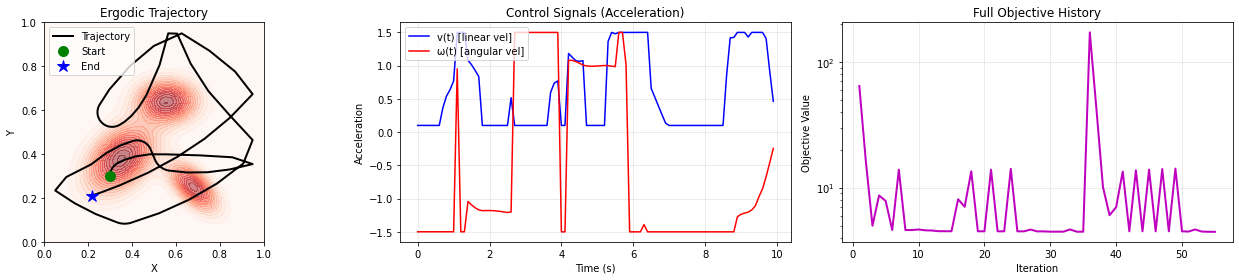

In [18]:
# --- Plot: Ergodic Trajectory, Control Signals (Acceleration), and Full Objective History ---

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# 1. Ergodic Trajectory
ax = axes[0]
pdf_vals = pdf(grids)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=20, cmap='Reds', alpha=0.5)
ax.plot(pos_final[:, 0], pos_final[:, 1], 'k-', lw=2, label='Trajectory')
ax.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
ax.plot(pos_final[-1, 0], pos_final[-1, 1], 'b*', markersize=12, label='End')
ax.set_title('Ergodic Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.set_aspect('equal')

# 2. Control Signals (Acceleration)
ax = axes[1]
ax.plot(tlist, u_final[:, 0], 'b-', lw=1.5, label='v(t) [linear vel]')
ax.plot(tlist, u_final[:, 1], 'r-', lw=1.5, label='ω(t) [angular vel]')
ax.set_title('Control Signals (Acceleration)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Acceleration')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Full Objective (Cost) History
ax = axes[2]
if len(cost_history) > 1:
    ax.plot(np.arange(1, len(cost_history)+1), cost_history, color='m', lw=2)
    ax.set_title('Full Objective History')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Objective Value')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
else:
    ax.axhline(final_ergodic_metric, color='m', lw=2, label='Final Objective')
    ax.set_title('Objective Value')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Objective Value')
    ax.legend()

plt.tight_layout()
plt.show()